In [1]:
import os
import numpy as np
from PIL import Image
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# CNN Image Classifier for Chess Pieces
### Can we predict chess piece label just from an image of the piece?

# Part 1 - Data
Data was aquired from https://www.kaggle.com/datasets/niteshfre/chessman-image-dataset/data

## Let's Load in the image data for all the pieces
#### * While also tracking the class of each image in a separate array *
#### Note that images are all different sizes. There are smart ways to resize images. This includes composing multiple transforms, like scaling down certain axes, then cropping, etc. For the purpose of this project I will simply resize all images to 256x256 RGB images.

In [2]:
# All piece names in Chess
pieces = np.array(["Bishop", "King", "Knight", "Pawn", "Queen", "Rook"])

# Store our images
image_data = []
# Store their labels
image_labels = np.array([])

fp = "data/"
for piece in pieces:
    
    # Directory of images for this piece
    piece_dir = fp + piece
    
    # Get all image names in this dir 
    piece_images = os.listdir(piece_dir)

    # For each image name
    for image in piece_images:
        
        # Ignore .gif files
        if (image.split(".")[-1] != "gif"):
        
            # Create the filepath
            image_fp = piece_dir + "/" + image

            # Open and resize the image
            img = np.array(Image.open(image_fp).resize((256,256)))

            image_data.append(img)
            image_labels = np.append(image_labels, piece)
        
image_data = np.array(image_data)

## Let's look at our data to see what we have
#### Looking at class distribution, we see that there is slight imbalance, but it is not bad enough to be concerned. We will continue normally. If the model is underperforming this could be something to tweak to improve improve. (Using resampling methods)

(555, 256, 256, 3)


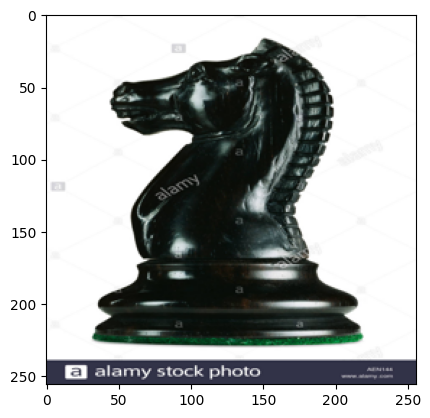

(array(['Bishop', 'King', 'Knight', 'Pawn', 'Queen', 'Rook'], dtype='<U32'),
 array([ 86,  76, 106, 107,  78, 102], dtype=int64))

In [3]:
print(image_data.shape)

# Render a "random" image in our dataset
plt.imshow(image_data[200])
plt.show()

np.unique(image_labels, return_counts = True)

## Our output classes need to be converted from strings to a numerical representation for use in our model

In [4]:
# Maps of piece name string to a unique integer identifier
pieceIDs = dict(zip(pieces,range(len(pieces))))
pieceIDs_inv = dict(zip(range(len(pieces)),pieces))

# Create array similar to image_labels but instead with numeric represetation of class
y = np.zeros_like(image_labels, dtype="uint8")

for i in range(len(image_labels)):
    label = image_labels[i]
    y[i] = pieceIDs[label]

# Part 2 - Model

## Let's make a train-test split

In [5]:
X = image_data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Network Architecture
We have images and a class to predict for each one. The obvious choice is a Convolutional Neural Network (CNN). Our CNN has input dimensionality that is the same as each image dimensionality. Each layer has a certain number of convolution filters that pass over the image. There can be multiple of these layers. Then there are standard Neural Network layers after that to lead to the output layer, which will be 6 nodes because we have 6 categories to classify. Along with dense layer paramaters, the CNN will also learn the best image filters to use during training.

In [6]:
model = keras.models.Sequential()
reg = keras.regularizers.l2(0.0005)

# First Convolutional layer
model.add(keras.layers.Conv2D(32, kernel_size=(3,3), activation="relu", input_shape=(256,256,3), kernel_regularizer=reg))
model.add(keras.layers.MaxPooling2D(2,2))

# Reduce Overfitting
model.add(keras.layers.Dropout(0.4))

# Second Convolutional Layer
model.add(keras.layers.Conv2D(64, kernel_size=(3,3), activation="relu", kernel_regularizer=reg))
model.add(keras.layers.MaxPooling2D(2,2))

# Reduce Overfitting
model.add(keras.layers.Dropout(0.4))

# Third Convolutional Layer
model.add(keras.layers.Conv2D(128, kernel_size=(3,3), activation="relu", kernel_regularizer=reg))
model.add(keras.layers.MaxPooling2D(2,2))

# Reduce Overfitting
model.add(keras.layers.Dropout(0.4))

# Flatten before moving to our dense layers
model.add(keras.layers.Flatten())

# First hidden Dense Layer
model.add(keras.layers.Dense(128, activation="relu"))

model.add(BatchNormalization())
model.add(keras.layers.Dropout(0.3))

# Output layer
model.add(keras.layers.Dense(len(pieces), activation="softmax"))

In [7]:
# Train our network
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy", # This is the best loss for integer represented classes
    metrics=["accuracy"]
)

model.fit(
    X_train,
    y_train,
    epochs=60,
    validation_data=(X_test, y_test)
)

Epoch 1/60
14/14 [==============================] - 5s 143ms/step - loss: 2.3079 - accuracy: 0.1734 - val_loss: 2.1797 - val_accuracy: 0.1982
Epoch 2/60
14/14 [==============================] - 1s 58ms/step - loss: 2.0016 - accuracy: 0.2365 - val_loss: 1.9982 - val_accuracy: 0.2523
Epoch 3/60
14/14 [==============================] - 1s 57ms/step - loss: 1.9046 - accuracy: 0.2568 - val_loss: 1.8438 - val_accuracy: 0.3153
Epoch 4/60
14/14 [==============================] - 1s 59ms/step - loss: 1.8344 - accuracy: 0.3018 - val_loss: 1.8156 - val_accuracy: 0.2432
Epoch 5/60
14/14 [==============================] - 1s 59ms/step - loss: 1.8883 - accuracy: 0.2680 - val_loss: 1.9641 - val_accuracy: 0.2162
Epoch 6/60
14/14 [==============================] - 1s 57ms/step - loss: 1.8569 - accuracy: 0.2793 - val_loss: 1.8795 - val_accuracy: 0.1622
Epoch 7/60
14/14 [==============================] - 1s 59ms/step - loss: 1.7792 - accuracy: 0.3514 - val_loss: 1.8874 - val_accuracy: 0.1532
Epoch 8/60
1

Epoch 59/60
14/14 [==============================] - 1s 67ms/step - loss: 0.1040 - accuracy: 0.9932 - val_loss: 1.7164 - val_accuracy: 0.3964
Epoch 60/60
14/14 [==============================] - 1s 65ms/step - loss: 0.0964 - accuracy: 0.9955 - val_loss: 1.6607 - val_accuracy: 0.4054


## Analysis 1
We got a testing accuracy of about 40%. It's not completely horrible but it is also not great.

## Below is my sad attempt at drawing a bishop. It looks pretty much like most bishops do, but let's see if our model agrees.

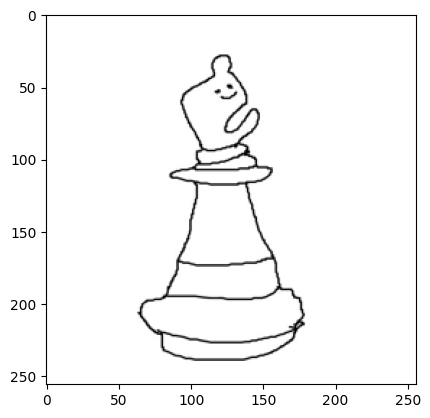

In [8]:
happy_bishop = np.array(Image.open("data/test/bishop.jpg").crop((400, 50, 975, 650)).resize((256,256)))
plt.imshow(happy_bishop)
plt.show()

## Below we see a very high confidence for the output corresponding to index 0

In [9]:
preds = model.predict(np.array([happy_bishop]))
preds

1/1 [==============================] - 0s 332ms/step


array([[0.45810044, 0.05774669, 0.12397884, 0.15795738, 0.11467974,
        0.08753696]], dtype=float32)

### Looking at the piece ID map we made earlier, that index corresponds to the class "Bishop" !!!!!!!

The model actually gave a very high confidence score to the correct answer despite having such average test accuracy. This is mainly because my bishop drawing is very simple and has no background noise.

In [10]:
pieceIDs_inv[preds.argmax()]

'Bishop'

## I will attempt this again, but by drawing a king purely from memory without a reference image.

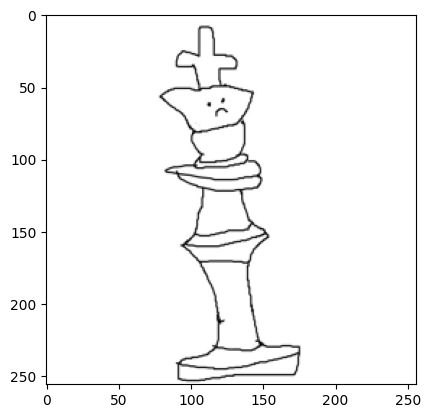

In [11]:
sad_king = np.array(Image.open("data/test/king.jpg").crop((300, 40, 1050, 740)).resize((256,256)))
plt.imshow(sad_king)
plt.show()

## He is sad because he is probably not drawn correctly.

In [12]:
preds = model.predict(np.array([sad_king]))
preds

1/1 [==============================] - 0s 29ms/step


array([[0.23042361, 0.40350688, 0.12557068, 0.04515773, 0.10140862,
        0.09393238]], dtype=float32)

In [13]:
pieceIDs_inv[preds.argmax()]

'King'

## Even here we see the highest confidence score for the "King" class.
Let's do this one more time, but with an intentionally bad drawing

## This is Randy, whom I will not even give the decency to call a Rook.

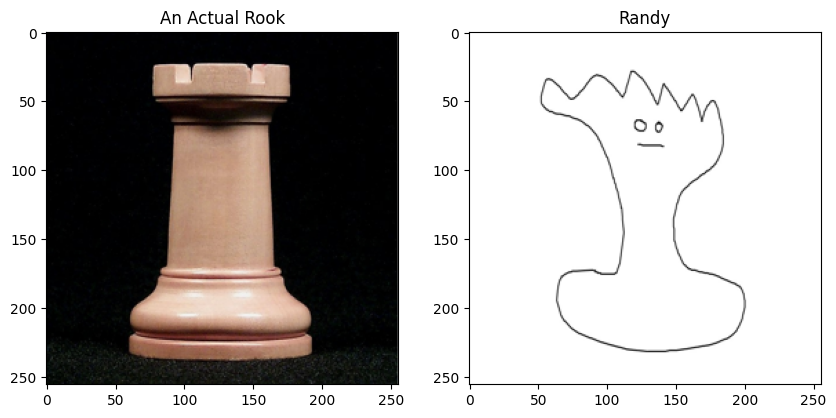

In [14]:
randy = np.array(Image.open("data/test/randy.jpg").resize((256,256)))

fig, ax = plt.subplots(1, 2, figsize=(10,10))
ax[0].imshow(X[516])
ax[0].set_title('An Actual Rook')
ax[1].imshow(randy)
ax[1].set_title('Randy')
plt.show()

In [15]:
preds = model.predict(np.array([randy]))
preds

1/1 [==============================] - 0s 32ms/step


array([[0.17600636, 0.05187905, 0.15990527, 0.07162815, 0.11052214,
        0.43005905]], dtype=float32)

In [16]:
pieceIDs_inv[preds.argmax()]

'Rook'

## Even with Randy's unfortunate visual situation, the model gave a relatively high confidence for the class "Rook" and actually made the correct classification. Though the Rook community won't take well to this.

### Important note that model training is random. After re-training the model many times, Randy's classification was not very consistent, and actually was often wrong. (The Rook community becomes happy again).

# Part 3 - Conclusion

Overall, the model initially seemed pretty average with a testing accuracy of about 40%. After some analysis however, we see that it does a fairly good job in practical situations, even when we try to give it bad input. This low accuracy is likely due to background noise in our data, which is a problem for a completely different model to solve. <br>
I would approach that problem by building a completely seperate transformer model to convert images into other images, but without the background. <br>
Note though that our model still underperforms sometimes and makes incorrect classifications for non-ideal images (like randy). <br><br>

How should we improve? <br>
Say this was more than just a fun project to get hands on experience with Machine Learning models. I would not start from scratch, but with some public pre-trained model. For this case I would use the VGG19 CNN model. I came accross Umar Saeed's analysis of the same dataset. They used the same approach, except starting from the VGG19 model and were able to achieve a 92% test accuracy! <br>
Moreover, I would search for some pre-trained background removing transformer model to use on all images before being inputted into the model. <br>

In [17]:
model.save('trained_model.keras')